# 物体検出入門
ここでは、簡単な2値分類プログラムを通して、画像処理の基本を学びます。

---

使用する環境はJupyterNotebook (or google-colaboratory)です。


まず、必要なモジュールのインポートを行います。

- urllib.request: URLから画像をダウンロードするために使用します。
- PIL.Image: 画像を読み込むために使用します。あとは、画像を変換するためにも使用します。
- matplotlib.pyplot.imshow: 画像を表示するために使用します。
- numpy: 画像をnumpy配列に変換するために使用します。numpyは画像も扱うこともできる算術演算ライブラリです。

In [7]:
# download
from urllib.request import urlretrieve
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np

画像をダウンロードします。
画像は、[こちら](https://s3.ap-northeast-1.wasabisys.com/download-raw/media/lecture/detection/image_b.png)

CoRE-1という大会を模したシミュレータの画像です。今回は、的の位置を検出するプログラムを作成します。

画像サイズは400x240にリサイズしています。また、RGBに変換しています。

In [20]:
image_url = 'https://s3.ap-northeast-1.wasabisys.com/download-raw/media/lecture/detection/image_b.png'
download_to = 'image_b.png'
urlretrieve(image_url, download_to)

# read
image = Image.open(download_to)
image = image.convert('RGB')
image = image.resize((400, 240))


表示してみます。
imshowはmatplotlib.pyplotの関数です。画像を表示するために使用します。

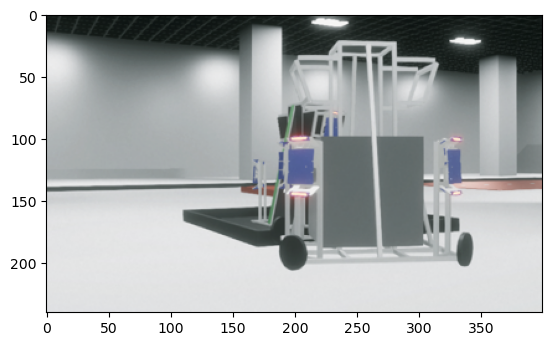

In [21]:
# show
imshow(image)

次に、画像をnumpy行列に変換します。
numpy行列にしてもimshowで表示ができます。

None
(400, 240)
RGB
(240, 400, 3)


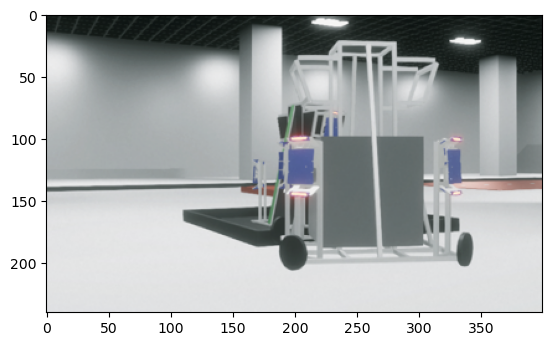

In [30]:
# convert to numpy array
image_array = np.asarray(image)
print(image_array.shape)

# show image
imshow(image_array)

## 2値化
画像を2値化します。2値化とは、画像を白と黒の2値に変換する処理です。2値化することで、画像の輪郭を抽出したり、画像のサイズを小さくしたりすることができます。
画像処理では最も基本的な処理です。

2値化の方法はいくつかありますが、ここでは、閾値を用いた青色の抽出をします。

### 色空間・RGB/HSV
色はRGBの3色で表現することが多いですが、画像処理だと同じ青でも黒っぽい青や白っぽい青の処理が大変だったりします。
ここで、出てくる表現がHSVです。HSVは、Hue(色相)、Saturation(彩度)、Value(明度)の3つの値で色を表現します。RGBと違い、色相は色の種類を表現するので、黒っぽい青でも白っぽい青でも同じ青として扱うことができます。

### 閾値処理
画像の1ピクセルは0〜255の256通りの色表現を行いますが、これをある一点を閾値にして区切り、閾値より大きいか小さいかで2値化します。
閾値付近の色は白か黒かどちらになるかわからないので、できる限り分布が少ないような閾値を選ぶ必要があります。

判別しやすい方法を解析して適切な閾値決定法を選ぶことが重要ですが、ここでは、固定値を用いて閾値処理を行います。

以下のプログラムで、HSVにおける青色の範囲を指定して、抽出します。

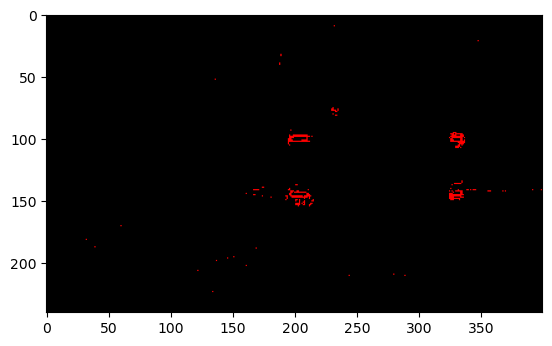

In [40]:
# 1st. rgb to hsv
image_hsv = image.convert('HSV')
image_hsv_array = np.asarray(image_hsv)
imshow(image_hsv_array)

blue_hue_min, blue_hue_max = 200, 270
copy_image_hsv_array = image_hsv_array.copy()
for i in range(copy_image_hsv_array.shape[0]):
    for j in range(copy_image_hsv_array.shape[1]):
        # 青色の範囲のみを残す
        if copy_image_hsv_array[i][j][0] > blue_hue_min and copy_image_hsv_array[i][j][0] < blue_hue_max:
            copy_image_hsv_array[i][j] = [255, 255, 255]
        else:
            copy_image_hsv_array[i][j] = [0, 0, 0]

# ======================================
copy_image_hsv = Image.fromarray(copy_image_hsv_array, mode='HSV')
copy_image_rgb = copy_image_hsv.convert('RGB')
copy_image_rgb_array = np.asarray(copy_image_rgb)
blue_image = copy_image_rgb_array.copy()

imshow(copy_image_rgb_array)


## ノイズ除去
画像処理を行う上で避けられないのがノイズです。ノイズとは、画像に含まれる不要な情報のことです。
ノイズがあると、画像処理の精度が落ちるだけでなく、ノイズがあるときとないときで処理が変わってしまうことがあります。

ノイズを除去する方法はいくつかあります。

| ノイズ除去方法 | 特徴 | 有効な場面 |
|:-----------|:------------|:------------|
| 平滑化フィルタ | ノイズを含む画素の値を平均化する | ノイズが外れ値でないとき（ノイズが外れ値のときは、平均値がノイズに近くなってしまう） |
| メディアンフィルタ | ノイズを含む画素の値を近傍画素の中央値に置き換える | ノイズが外れ値のとき |
| ガウシアンフィルタ | ノイズを含む画素の値を近傍画素の重み付き平均値に置き換える | ぼかしても問題ないとき |

他にも、各ノイズ除去法の欠点を補うフィルタも存在します。（ガウシアンフィルタの欠点を補うバイラテラルフィルタなど）

ここでは、メディアンフィルタを用います。

### メディアンフィルタ
メディアンフィルタは、ノイズを含む画素の値を近傍画素の中央値に置き換えるフィルタです。
次の手順でフィルタをかけていきます。

1. フィルターサイズが3の場合、画像の左上から3x3の領域を取り出す
2. 3x3の領域の中央値を計算する（中央値は、値を小さい順に並べたときに、真ん中の値）
3. 3x3の領域の画素を中央値に置き換える
4. 画像の右にずらして、1〜3を繰り返す



今回は7x7のフィルタをかけます。フィルタのことをカーネルとも呼びます。
フィルターサイズが大きいほど、ノイズ除去効果が高くなりますが、画像のぼやけが大きくなります。

フィルタ内の値を全て足すと1になるように正規化することで、画像の明るさを変えないようにします。

In [ ]:
# median filter
filter_size = 7
filter_array = np.zeros((filter_size, filter_size))
for i in range(filter_size):
    for j in range(filter_size):
        filter_array[i][j] = 1
filter_array = filter_array / filter_size**2


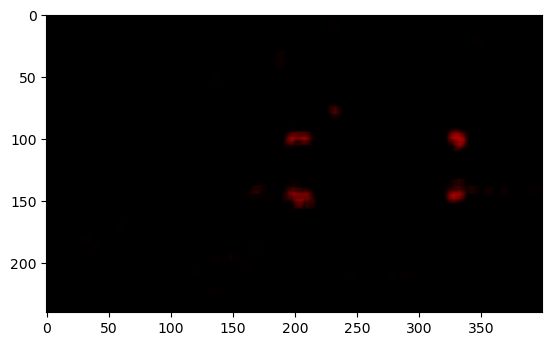

In [57]:
# 2nd. padding
# パディングとは：画像の周りに余白を作ること(理由：フィルタリングを行う際に、画像の端のピクセルの処理ができないため)
padding_size = filter_size // 2
padding_image = np.zeros((blue_image.shape[0] + padding_size * 2, blue_image.shape[1] + padding_size * 2, blue_image.shape[2]))
padding_image[padding_size:padding_image.shape[0] - padding_size, padding_size:padding_image.shape[1] - padding_size] = blue_image

# 3rd. filtering
copy_blue_image = blue_image.copy()
for i in range(padding_size, padding_image.shape[0] - padding_size):
    for j in range(padding_size, padding_image.shape[1] - padding_size):
        for k in range(padding_image.shape[2]):
            copy_blue_image[i - padding_size][j - padding_size][k] = np.sum(padding_image[i - padding_size:i + padding_size + 1, j - padding_size:j + padding_size + 1, k] * filter_array)

# ========================================================================================================
imshow(copy_blue_image)
bluer_image = copy_blue_image.copy()

## 輪郭抽出
次に輪郭の抽出を行います。

輪郭の抽出については、2値化した画像について、1→0あるいは0→1の変化がある画素を抽出して輪郭を近似。その輪郭のリストを返す処理です。

少し複雑なので、ここでは、OpenCVの関数 findContours を用います。

描画には、OpenCVの関数 drawContours を用います。

5
201 148
325 143
197 143
196 98
326 95


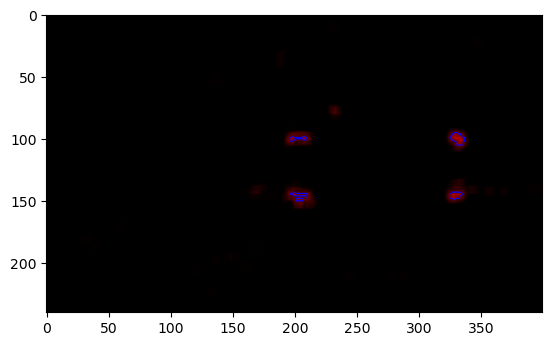

In [94]:
#輪郭抽出
import cv2

# 1st. binarize
gray_image = cv2.cvtColor(bluer_image, cv2.COLOR_RGB2GRAY)
threshold = 30
binarized_image = gray_image.copy()
binarized_image[binarized_image < threshold] = 0
binarized_image[binarized_image >= threshold] = 255

# 2rd. find contours
contours, hierarchy = cv2.findContours(binarized_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

# ========================================================================================================
# print
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    print(x, y)

# draw contours
contour_image = bluer_image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 0, 255), 1)

imshow(contour_image)

大まかな輪郭は抽出できたものの、表示としては5個の輪郭が表示されてしまっています。
これをx軸方向に近い輪郭の座標を結合して最終的な位置を決定します。

y軸方向にロボットが複数台存在しないためです。

197 121
325 119


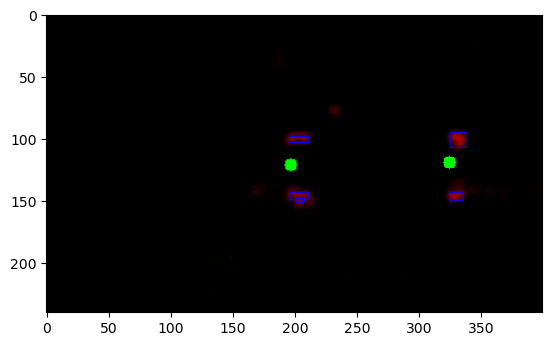

In [95]:
merged_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    merged = False
    for i in range(len(merged_contours)):
        if abs(x - merged_contours[i][0]) < 10:
            merged_contours[i] = [(x + merged_contours[i][0]) // 2, (y + merged_contours[i][1]) // 2]
            merged = True
            break
    if not merged:
        merged_contours.append([x, y])

# ========================================================================================================
for contour in merged_contours:
    print(contour[0], contour[1])

# draw circle and rectangle
circle_image = bluer_image.copy()
for contour in merged_contours:
    x, y = contour
    cv2.circle(circle_image, (x, y), 5, (0, 255, 0), -1)
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(circle_image, (x, y), (x + w, y + h), (0, 0, 255), 1)

imshow(circle_image)

完成です！
よりロバスト性を上げるためにどうすればいいのか、いろいろと調べてみましょう。

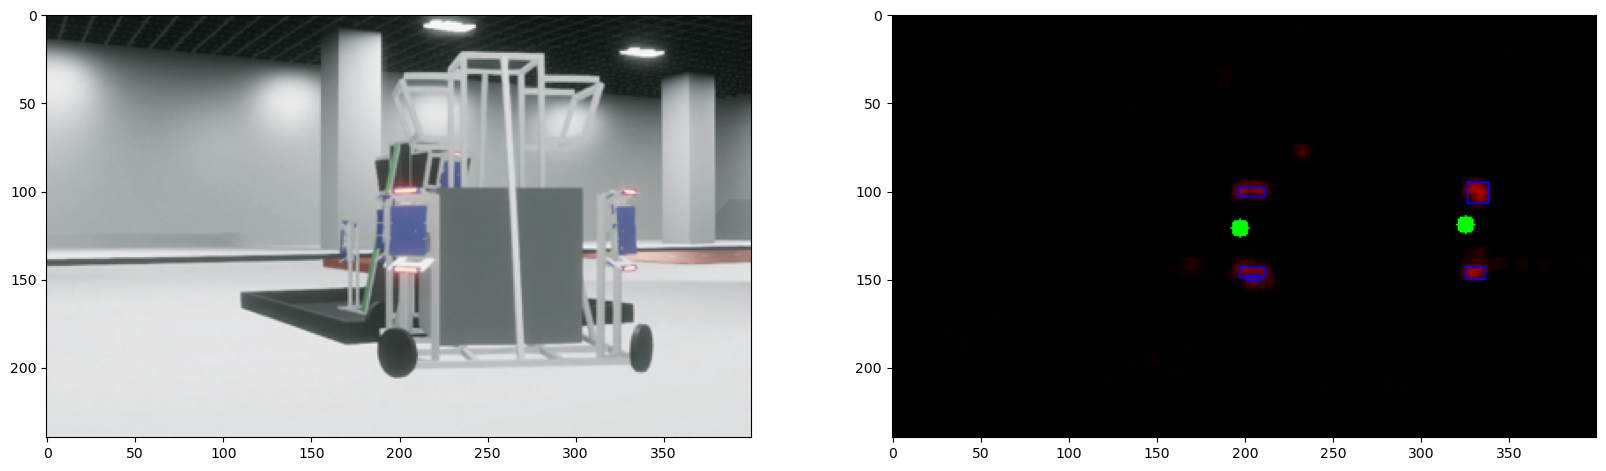

In [85]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image)
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(circle_image)
plt.show()